In [1]:
import numpy as np
import copy as cp
import scipy
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import sys
import time
import matplotlib.pyplot as plt

In [2]:
def inputamp(file_path):  #データパス
    with open(file_path, 'r') as f:
        lines = f.readlines()
        n_t = len(lines)
        RVZ = np.zeros((n_t+1, 2), dtype=np.float64)
        for index, line in  enumerate(lines):
            line_array = line.strip().split()
            RVZ[index+1, 0] = float(line_array[0])
            RVZ[index+1, 1] = float(line_array[1])
        return RVZ, n_t

In [3]:
# 要素剛性マトリックス作成（local）
def sm_3dfrm(EA,GJ,EIy,EIz,x1,y1,z1,x2,y2,z2):
    ek=np.zeros((12,12),dtype=np.float64) # local stiffness matrix
    xx=x2-x1
    yy=y2-y1
    zz=z2-z1
    el=np.sqrt(xx**2+yy**2+zz**2)
    ek[ 0, 0]= EA/el
    ek[ 0, 6]=-EA/el
    ek[ 1, 1]= 12*EIz/el**3
    ek[ 1, 5]=  6*EIz/el**2
    ek[ 1, 7]=-12*EIz/el**3
    ek[ 1,11]=  6*EIz/el**2
    ek[ 2, 2]= 12*EIy/el**3
    ek[ 2, 4]= -6*EIy/el**2
    ek[ 2, 8]=-12*EIy/el**3
    ek[ 2,10]= -6*EIy/el**2
    ek[ 3, 3]= GJ/el
    ek[ 3, 9]=-GJ/el
    ek[ 4, 2]= -6*EIy/el**2
    ek[ 4, 4]=  4*EIy/el
    ek[ 4, 8]=  6*EIy/el**2
    ek[ 4,10]=  2*EIy/el
    ek[ 5, 1]=  6*EIz/el**2
    ek[ 5, 5]=  4*EIz/el
    ek[ 5, 7]= -6*EIz/el**2
    ek[ 5,11]=  2*EIz/el
    ek[ 6, 0]=-EA/el
    ek[ 6, 6]= EA/el
    ek[ 7, 1]=-12*EIz/el**3
    ek[ 7, 5]= -6*EIz/el**2
    ek[ 7, 7]= 12*EIz/el**3
    ek[ 7,11]= -6*EIz/el**2
    ek[ 8, 2]=-12*EIy/el**3
    ek[ 8, 4]=  6*EIy/el**2
    ek[ 8, 8]= 12*EIy/el**3
    ek[ 8,10]=  6*EIy/el**2
    ek[ 9, 3]=-GJ/el
    ek[ 9, 9]= GJ/el
    ek[10, 2]= -6*EIy/el**2
    ek[10, 4]=  2*EIy/el
    ek[10, 8]=  6*EIy/el**2
    ek[10,10]=  4*EIy/el
    ek[11, 1]=  6*EIz/el**2
    ek[11, 5]=  2*EIz/el
    ek[11, 7]= -6*EIz/el**2
    ek[11,11]=  4*EIz/el
    return ek

In [4]:
def mass_3dfrm(ae_mass, npoin, nfree):
    # 番兵追加
    mass = np.append(ae_mass, 0.0)
    mass = np.insert(mass, 0, 0.0)
    ret = np.eye(npoin*nfree, dtype=np.float64)
    node_mass_array = np.zeros(npoin, dtype=np.float64)
    for i in range(0, len(mass) - 1):
        node_mass = (mass[i] + mass[i+1]) / 2.0
        node_mass_array[i] = node_mass
        for j in range(0, nfree):
            idx = i*nfree + j
            ret[idx,idx] *= node_mass
    return ret, node_mass_array

In [5]:
def dumping_3dfrm(gamma, omega, mass_mat, gk):
    m = gamma * mass_mat
    gk = omega * gk    
    for i in range(0, len(gk)):
        gk[i, i] += m[i, i]        
    return gk

In [6]:
# newmark マトリックスを作成
# newmarkのparam: alpha, beta
def newmark_3dfrm(delta_t, alpha, beta, gk, mass_mat, c_mat): 
    return (1.0/beta/delta_t**2) * mass_mat  \
         + (alpha/beta/delta_t) * c_mat \
         + gk

In [7]:
def print_e_dis(dis, ep=1):
    for i in range(len(dis)):
        if i % ep == 0:
            print(i)    
            print('ux uy uz rux ruy ruz')
            for j in range(11):                
                print(dis[i][j*6], dis[i][j*6+1], dis[i][j*6+2], dis[i][j*6+3], dis[i][j*6+4], dis[i][j*6+5])
            print('-----')

def print_e_dis_xyz(dis, ep=1):
    for i in range(len(dis)):
        if i % ep == 0:
            print(i)    
            print('ux uy uz')            
            for j in range(11):
                print(dis[i][j*6], dis[i][j*6+1], dis[i][j*6+2])
            print('-----')
            
def printcords(cords, ep=1):
    for i in range(len(cords)):
        if i % ep == 0:
            print(i)
            print('x: ', cords[i][0])
            print('y: ', cords[i][1])
            print('z: ', cords[i][2])  
            
def printcords_from_init(cords, ep=1):
    initCords = cords[0]
    for i in range(len(cords)):
        if i % ep == 0:
            print(i)
            tmpCords = cords[i] - initCords
            print('x: ', tmpCords[0])
            print('y: ', tmpCords[1])
            print('z: ', tmpCords[2])

In [8]:
def plot_coords_by_step(cords, node_ids=None, save=False, title='Coordinates'):        
    step_num = cords.shape[0] - 1
    node_num = cords.shape[2]
    if node_ids == None:
        node_ids = [i+1 for i in range(node_num)]
    step = np.zeros(step_num, dtype=np.int)
    for i in range(step_num):
        step[i] = i    
    
    axises = ['x', 'y', 'z']
    for i in range(3): # x, y, z
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(1, 1, 1)
        axis = axises[i]
        for node_id in node_ids:
            data = np.zeros(step_num, dtype=np.float64)
            for k in range(step_num):
                data[k] = cords[k, i, node_id-1]
            ax.plot(step, data, label='{0} {1}'.format(axis, node_id))
        plt.title('{0}: displacement'.format(axis))
        plt.xlabel('step', fontsize=18)
        plt.ylabel('Coord', fontsize=18)
        if save:
            plt.savefig('{0}_{1}.png'.format(title, axis))        
        plt.show() 
        
# plot_cords_by_step(cordsG_plus_dis, [11])  

def plot_disG_by_step(disG, node_ids=None, save=False, title='Displacement from origin'):
    step_num = disG.shape[0]
    nfree = 6
    node_num = disG.shape[1] // 6
    if node_ids == None:
        node_ids = [i+1 for i in range(node_num)]
    step = np.zeros(step_num, dtype=np.int)
    for i in range(step_num):
        step[i] = i    
    
    labels = ['ux', 'uy', 'uz', 'rux', 'ruy', 'ruz']
    for i in range(6): # ux, uy, uz, rux, ruy, ruz
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(1, 1, 1)
        label = labels[i]
        for node_id in node_ids:
            data = np.zeros(step_num, dtype=np.float64)
            for j in range(step_num):
                data[j] = disG[j, 6*(node_id-1)+i]
            ax.plot(step, data, label='{0} {1}'.format(label, node_id))
        plt.title('{0} displacement'.format(label))
        plt.xlabel('step', fontsize=18)
        plt.ylabel('Coord', fontsize=18)
        if save:
            plt.savefig('{0}_{1}.png'.format(title, label))        
        plt.show() 
        
# plot_disG_by_step(disG, [11])

In [10]:
def get_abaqus_data(file_path, step, node_num):
    ret = np.zeros((step, node_num*6), dtype=np.float64)
    with open(file_path, 'r') as f:
        for i in range(step):
            line = '-'
            while (len(line) < 20 or line[0] != '-'):
                line = f.readline()
            for j in range(node_num):
                l = f.readline().strip().split()
                for index,ele in enumerate(l):
                    if index > 0:
                        ret[i, j*6+index-1] = float(ele)
    return ret
# get_abaqus_data('3d-beam-rot-onlyU.txt', 998, 11)

In [11]:
def plot_compare_abaqus_dis(abaqusU, disG, node_ids=None, save=False, title='Displacement compare with abaqus'):
    step_num = disG.shape[0]
    nfree = 6
    node_num = disG.shape[1] // 6
    if node_ids == None:
        node_ids = [i+1 for i in range(node_num)]
    step = np.zeros(step_num, dtype=np.int)
    for i in range(step_num):
        step[i] = i    
    
    labels = ['ux', 'uy', 'uz', 'rux', 'ruy', 'ruz']
    for i in range(6): # ux, uy, uz, rux, ruy, ruz
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(1, 1, 1)
        label = labels[i]
        for node_id in node_ids:
            data = np.zeros(step_num, dtype=np.float64)
            abaqus_data = np.zeros(step_num, dtype=np.float64)
            for j in range(step_num):
                data[j] = disG[j, 6*(node_id-1)+i]
                abaqus_data[j] = abaqusU[j, 6*(node_id-1)+i]
            ax.plot(step, data, label='{0} {1}'.format(label, node_id))
            ax.plot(step, abaqus_data, label='abaqus {0} {1}'.format(label, node_id))            
        plt.title('{0} displacement'.format(label))
        plt.xlabel('step', fontsize=18)
        plt.ylabel('Coord', fontsize=18)
        if save:
            plt.savefig('{0}_{1}.png'.format(title, label))        
        plt.show() 
        
def calc_diff(abaqusU,disG, node_id=None):    
    step_num = disG.shape[0]
    nfree = 6
    node_num = disG.shape[1] // 6
    ret = {}
    if node_id == None:
        node_id = [i+1 for i in range(node_num)]    
        
    labels = ['ux', 'uy', 'uz', 'rux', 'ruy', 'ruz']
    for nid in node_id:
        ret[nid] = {}
        for index, label in enumerate(labels):
            diff = np.abs(abaqusU.T[(nid-1)*6+index] - disG.T[(nid-1)*6+index])
            max_diff = np.max(diff)
            total_diff = np.sum(diff)
            average_diff = np.average(diff)
            ret[nid][label] = {}
            ret[nid][label]['max_diff'] = max_diff
            ret[nid][label]['total_diff'] = max_diff
            ret[nid][label]['average_diff'] = max_diff
    return ret
# calc_diff(abaqus_dis, disG)

In [12]:
# diff = calc_diff(abaqus_dis,disG)
# diff[11]

In [13]:
def plot_e_dis(e_disG, node_id=None, pos=None, save=False, title='elastic_dis'):    
    step_num = e_disG.shape[0]
    nfree = 6
    node_num = disG.shape[1] // 6
    if node_id == None:
        node_id = node_num
    if pos==None:
        pos=1
    
    step = np.zeros(step_num, dtype=np.int)
    for i in range(step_num):
        step[i] = i
        
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    labels = ['ux', 'uy', 'uz', 'rux', 'ruy', 'ruz']
    label = labels[pos]
    ax.plot(step, e_disG.T[(node_id-1)*6+pos], label='{0} {1}'.format(label, node_id))
    plt.title('{0}'.format(label))
    plt.xlabel('step', fontsize=18)
    plt.ylabel('elastic displacement', fontsize=18)
    if save:
        plt.savefig('{0}_{1}.png'.format(title, label))        
    plt.show() 
# plot_e_dis(e_disL, 11)    

In [14]:
def main_3d_NEWMARK_FEM(amp_file_path, delta_t):
        start=time.time()
        args = sys.argv        
        nod=2
        nfree=6
        alpha=0.5  # newmark param
        beta=0.25  # newmark param
        gamma=0.01 # dumping param
        omega=0.01 # dumping param
        npoin = 11
        nele = 10
        npfix = 1
        RVZ, n_t = inputamp(amp_file_path)
#         print(RVZ.shape)
#         print(RVZ)
#         return
        RUZ = np.zeros((n_t+1, 2), dtype=np.float64)
        RAZ = np.zeros((n_t+1, 2), dtype=np.float64)
        RAZ[1, 1] = RVZ[1, 1] / delta_t # 初加速度        
        for i in range(1, n_t+1):
            RUZ[i, 0] = RVZ[i, 0]
            RAZ[i, 0] = RVZ[i, 0]      
            if i > 1:
                RUZ[i, 1] = (RVZ[i, 1] + RVZ[i-1, 1])/2 * delta_t + RUZ[i-1, 1]
                if i < n_t:
                    RAZ[i, 1] = (RVZ[i+1, 1]-RVZ[i-1, 1])/2/delta_t
#         print(RAZ)            
#         return
        ae = np.zeros((8, 10), dtype=np.float64)
        for i in range(10):
            ae[0, i] = 5.79e-5
            ae[1, i] = 8.04e-10
            ae[2, i] = 0.0
            ae[3, i] = 8.04e-10
            ae[4, i] = 4.21e-9
            ae[5, i] = 1e11
            ae[6, i] = 7.143e10
            ae[7, i] = 5.79e-5 * 0.1 * 1550
        node = np.zeros((nod + 1, nele), dtype=np.int)
        for i in range(nele):
            node[0, i] = i+1
            node[1, i] = i+2
            node[2, i] = i+1
            
        initCordinatesG = np.zeros((3, npoin), dtype=np.float64)
        for i in range(npoin):
            initCordinatesG[0, i] = i * 0.1
            initCordinatesG[1, i] = 0
            initCordinatesG[2, i] = 0
            
        mpfix = np.zeros((n_t+1, nfree, npoin), dtype=np.int)
        rdis = np.zeros((n_t+1, nfree, npoin), dtype=np.float64)
        for i in range(1, n_t+1):
            mpfix[i, 0, 0] = 1
            mpfix[i, 1, 0] = 1
            mpfix[i, 2, 0] = 1
            mpfix[i, 3, 0] = 1
            mpfix[i, 4, 0] = 1
            mpfix[i, 5, 0] = 1
            rdis[i, 0, 0] = 0
            rdis[i, 1, 0] = 0
            rdis[i, 2, 0] = 0
            rdis[i, 3, 0] = 0
            rdis[i, 4, 0] = 0
            rdis[i, 5, 0] = 0

        mass_mat, node_mass_array=mass_3dfrm(ae[7], npoin, nfree)
        
        e_accL=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
        e_vecL=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
        e_disL=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)        
        e_accG=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
        e_vecG=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)       
        e_disG=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)        
        accG=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
        vecG=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)       
        disG=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
        
        cordinatesG=np.zeros((n_t+1, 3, npoin), dtype=np.float64)
        cordinatesG_plus_dis=np.zeros((n_t+1, 3, npoin), dtype=np.float64)
        disG_plus_dis=np.zeros((n_t+1, 6, npoin), dtype=np.float64)
        cordinatesG[0] = initCordinatesG
        cordinatesG[1] = initCordinatesG
        cordinatesG_plus_dis[0] = initCordinatesG
        cordinatesG_plus_dis[1] = initCordinatesG        
        
        for step in range(1, n_t):
            ir=np.zeros(nod*nfree, dtype=np.int)
            kL=np.zeros((nfree*npoin, nfree*npoin), dtype=np.float64) # Local stifness matrix
            rvz = RVZ[step, 1]
            ruz = RUZ[step, 1]
            raz = RAZ[step, 1]
            rot_mat = np.array(([[np.cos(ruz), -np.sin(ruz), 0.0],[np.sin(ruz), np.cos(ruz), 0.0],[0.0, 0.0, 1.0]]), dtype=np.float64)
            cordsG = np.dot(rot_mat, initCordinatesG)
            cordinatesG[step] = cordsG
            
            fG = np.zeros(npoin*nfree, dtype=np.float64)
            fL = np.zeros(npoin*nfree, dtype=np.float64)
            origin_x = cordsG[0, 0]
            origin_y = cordsG[1, 0]
            origin_z = cordsG[2, 0]
            for i in range(npoin):
                cordG_x = cordsG[0, i]
                cordG_y = cordsG[1, i]
                cordG_z = cordsG[2, i]
                r = np.sqrt(abs(cordG_x - origin_x)**2 + abs(cordG_y - origin_y)**2 + abs(cordG_z - origin_z)**2)
                axG = -r * (raz*np.sin(ruz) + (rvz**2)*np.cos(ruz))
                ayG = r * (raz*np.cos(ruz) - (rvz**2)*np.sin(ruz))
                azG = 0
                node_mass = node_mass_array[i]
                fxG = -node_mass*axG
                fyG = -node_mass*ayG
                fzG = 0
                fG[i*6 + 0] = fxG
                fG[i*6 + 1] = fyG
                fG[i*6 + 2] = fzG
                fL[i*6 + 0] = 0
                fL[i*6 + 1] = fyG * np.cos(ruz) - fxG * np.sin(ruz)
                fL[i*6 + 2] = fzG
                
            # assembly stifness matrix & load vector
            for ne in range(0, nele):
                i=node[0,ne]-1
                j=node[1,ne]-1
                m=node[2,ne]-1
                x1G=cordsG[0,i]; y1G=cordsG[1,i]; z1G=cordsG[2,i]
                x2G=cordsG[0,j]; y2G=cordsG[1,j]; z2G=cordsG[2,j]
                cordsL1 = np.dot(rot_mat.T, np.array([x1G, y1G, z1G]))
                cordsL2 = np.dot(rot_mat.T, np.array([x2G, y2G, z2G]))
                x1L = cordsL1[0]
                y1L = cordsL1[1]
                z1L = cordsL1[2]
                x2L = cordsL2[0]
                y2L = cordsL2[1]
                z2L = cordsL2[2]
                
                A    =ae[0,m]  # 断面積
                I11  =ae[1,m]  # y軸周り断面二次モーメント 
                I12  =ae[2,m]  # x軸周り断面二次モーメント
                I22  =ae[3,m]  # z軸周り断面二次モーメント
                J    =ae[4,m]  # ねじり定数
                E    =ae[5,m]  # ヤング率
                G    =ae[6,m]  # せん断弾性係数
                EA=E*A
                GJ=G*J
                EIy=E*I11
                EIz=E*I22
                ekL=sm_3dfrm(EA,GJ,EIy,EIz,x1L,y1L,z1L,x2L,y2L,z2L) # local element stiffness matrix                                
                ir[11]=6*j+5; ir[10]=ir[11]-1; ir[9]=ir[10]-1; ir[8]=ir[9]-1; ir[7]=ir[8]-1; ir[6]=ir[7]-1
                ir[5] =6*i+5; ir[4] =ir[5]-1 ; ir[3]=ir[4]-1 ; ir[2]=ir[3]-1; ir[1]=ir[2]-1; ir[0]=ir[1]-1                
                # assemble
                for i in range(0, nod*nfree):
                    it=ir[i]
                    for j in range(0, nod*nfree):
                        jt=ir[j]
                        kL[it, jt] = kL[it, jt] + ekL[i,j]
            
#             検証用            
#             kL_eig_val, kL_eig_vec = np.linalg.eig(kL)
#             print(sorted(kL_eig_val)[:7])
#             eig_val, eig_vec = scipy.linalg.eig(kL, mass_mat)
#             return sorted(eig_val)[:7]
            
            c_mat=dumping_3dfrm(gamma, omega, mass_mat, kL)
            newmark_mat=newmark_3dfrm(delta_t, alpha, beta, kL, mass_mat, c_mat)
            tmp_for_mass = (1.0/beta/delta_t**2)  * e_disL[step-1] \
                         + (1.0/beta/delta_t)     * e_vecL[step-1] \
                         + ((1.0/2/beta)-1.0)     * e_accL[step-1]
            
            tmp_for_c = (alpha/beta/delta_t)            * e_disL[step-1] \
                      + ((alpha/beta)-1.0)              * e_vecL[step-1] \
                      + delta_t * ((alpha/2/beta)-1.0)  * e_accL[step-1]                       
            
            fL = fL + np.dot(mass_mat, tmp_for_mass) + np.dot(c_mat, tmp_for_c)  
            # boudary conditions
            for i in range(0, npoin):
                for j in range(0, nfree):
                    if mpfix[step, j, i] == 1:
                        iz=i*nfree+j
                        fL[iz]=0.0

            for i in range (0, npoin):
                for j in range(0, nfree):
                    if mpfix[step, j, i] == 1:
                        iz=i*nfree+j
                        newmark_mat[:,iz]=0.0
                        newmark_mat[iz,iz]=1.0
            # 疎行列圧縮格納
            sp_newmark_mat = csr_matrix(newmark_mat)
            e_disL[step] = spsolve(sp_newmark_mat, fL, use_umfpack=True)
                        
            # 拘束条件を再代入する
            for i in range(0, npoin):
                for j in range(0, nfree):
                    if mpfix[step, j, i] == 1:
                        iz=i*nfree+j
                        e_disL[step, iz] = rdis[step, j, i]
                        
            # 速度, 加速度計算            
            e_accL[step] = (1.0/beta/delta_t**2)  * (e_disL[step] - e_disL[step-1]) \
                            - (1.0/beta/delta_t)     * e_vecL[step-1] \
                            - ((1.0/2/beta)-1.0)     * e_accL[step-1]
            
            e_vecL[step] = (alpha/beta/delta_t)         * (e_disL[step] - e_disL[step-1]) \
                            + (1.0-(alpha/beta))           * e_vecL[step-1] \
                            + delta_t*(1.0-(alpha/2/beta)) * e_accL[step-1]
            
            e_disG[step] = cp.deepcopy(e_disL[step])
#             print(cordinatesG[step])
#             return
            for i in range(npoin):
                e_disG[step][i*6:i*6+3] = np.dot(rot_mat, e_disG[step][i*6:i*6+3])
                
                cordinatesG_plus_dis[step, 0, i] = cordinatesG[step, 0, i] + e_disG[step-1][i*6]
                cordinatesG_plus_dis[step, 1, i] = cordinatesG[step, 1, i] + e_disG[step-1][i*6+1]
                cordinatesG_plus_dis[step, 2, i] = cordinatesG[step, 2, i] + e_disG[step-1][i*6+2]                  
                    
                disG[step][i*6] = cordinatesG_plus_dis[step][0][i] - initCordinatesG[0][i] # ux
                disG[step][i*6+1] = cordinatesG_plus_dis[step][1][i] - initCordinatesG[1][i] # uy
                disG[step][i*6+2] = cordinatesG_plus_dis[step][2][i] - initCordinatesG[2][i] # uz                
                disG[step][i*6+5] = e_disG[step][i*6+5] + RUZ[step, 1] # ruz
#             if (step % 10 == 0):
#                 step_time = time.time()-start
#                 print('{0} step: {1:.3f}'.format(step, step_time))
        # print out result
        dtime=time.time()-start        
        print('time: {0:.3f}'.format(dtime)+'sec')
        return e_disL[1:-1], e_disG[1:-2], disG[1:-1], cordinatesG_plus_dis[1:], cordinatesG[1:]

In [15]:
e_disL, e_disG, disG, cordsG_plus_dis, cordsG = main_3d_NEWMARK_FEM('amp_vrz_等角加速度_3sec_1000step_180deg.txt', 0.003)

time: 2.384sec


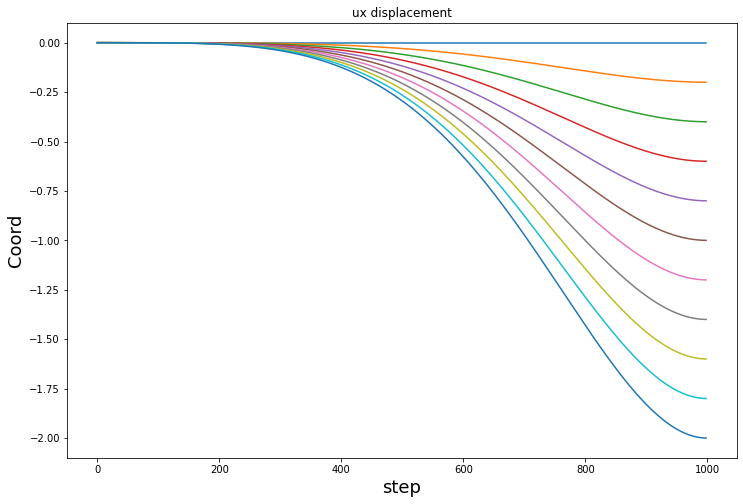

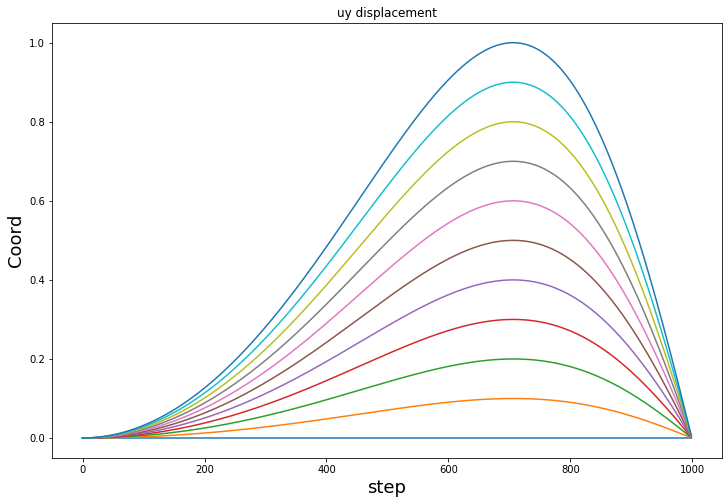

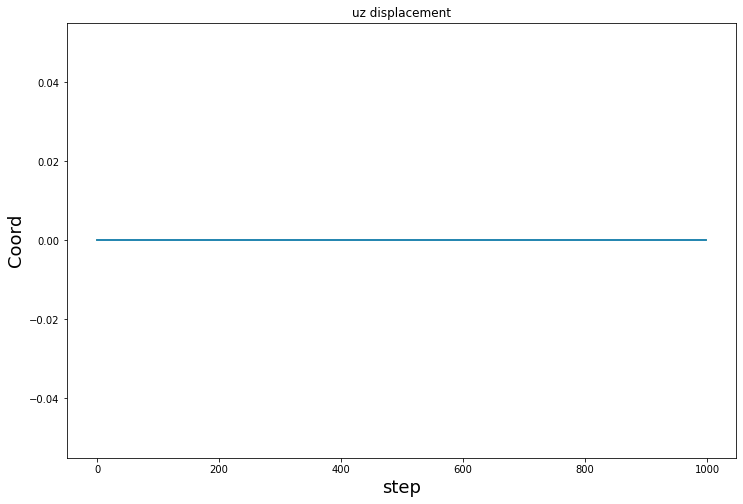

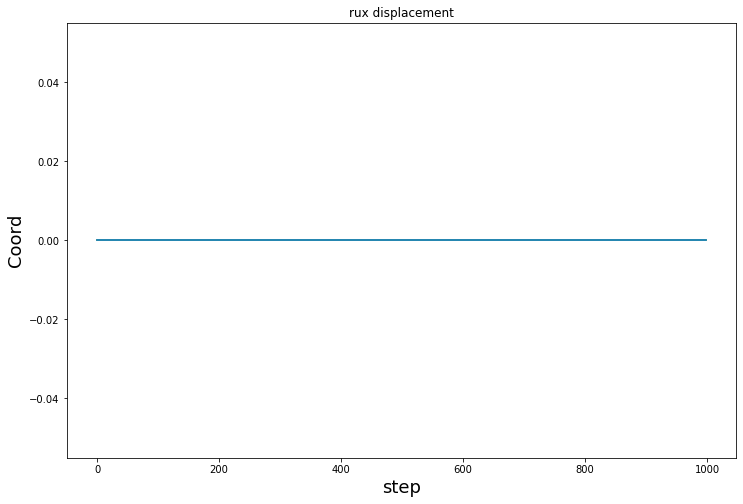

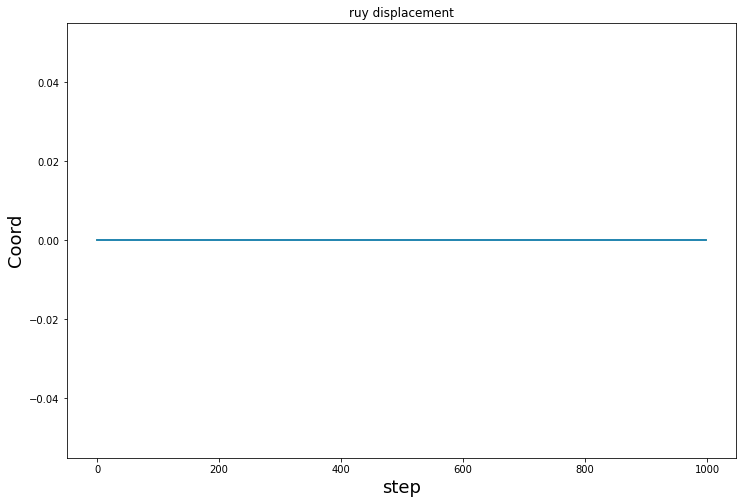

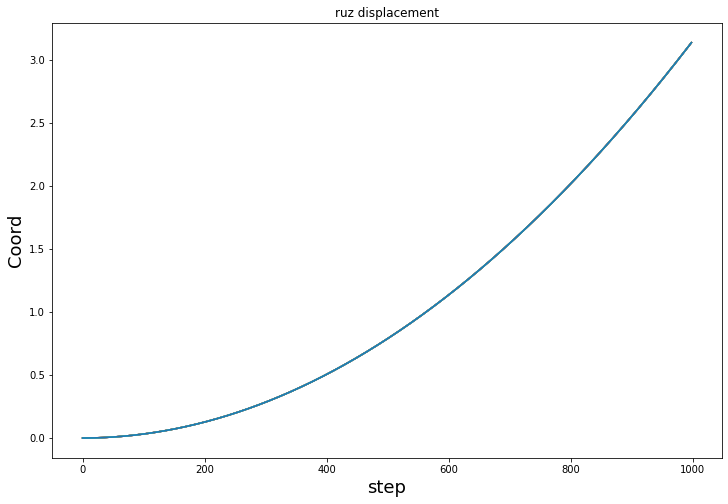

In [16]:
plot_disG_by_step(disG)

In [ ]:
printcords(cordsG, 1)

In [ ]:
printcords_from_init(disG, 50)

In [ ]:
check2 = main_3d_NEWMARK_FEM('test_verification1.txt')

In [ ]:
z2 = np.zeros(len(check), dtype=np.float64)

In [ ]:
for i in range(1, len(z2)):
    z2[i] = check2[i * 10]

In [ ]:
a = np.array([[[0, 1], [2, 3], [4, 5]], [[6, 7], [8, 9], [10, 11]]])

In [ ]:
a[0][1]

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(check, label='newmark_10e4', color=(0, 0, 1))
# plt.savefig('newmark_verif.png')
plt.show()

In [ ]:
data = {
    '精度1e3': z1,
    '精度1e4': z2,
    '精度1e5': z3
}

In [ ]:
data

In [ ]:
import pickle

In [ ]:
with open('newmark精度テストデータ1', 'wb') as f1:
    pickle.dump(data, f1)

In [ ]:
with open('精度テスト1', 'rb') as r1:
    r_data1 = pickle.load(r1)

In [ ]:
r_data1

In [ ]:
diff = 0.0
max_diff = 0.0
for (i, j) in zip(z1, z2):
    diff += abs(i - j)
    max_diff = max(max_diff, abs(i - j))

average_diff = diff / len(z1)    
print('average_diff: {0}, max_diff: {1}'.format(average_diff, max_diff))

In [ ]:
check3 = main_3d_NEWMARK_FEM('test_verification1.txt')

In [ ]:
z3 = np.zeros(len(check), dtype=np.float64)
for i in range(1, len(z3)):
    z3[i] = check3[i * 100]

In [ ]:
data['精度10e5'] = z3

In [ ]:
data

In [ ]:
with open('精度テスト1', 'wb') as f1:
    pickle.dump(data, f1)

In [ ]:
diff1 = 0.0
max_diff1 = 0.0
for (i, j) in zip(z1, z3):
    diff1 += abs(i - j)
    max_diff1 = max(max_diff1, abs(i - j))

average_diff1 = diff1 / len(z1)    
print('average_diff: {0}, max_diff: {1}'.format(average_diff1, max_diff1))

In [ ]:
diff1

In [ ]:
diff_data = {
    '精度1e3': {
        'dis': z1,
        'total_diff': diff1,
        'average_diff': average_diff1,
        'max_diff': max_diff1
    },
    '精度1e4': {
        'dis': z2,
        'total_diff': diff2,
        'average_diff': average_diff2,
        'max_diff': max_diff2
    }
}

In [ ]:
diff2 = 0.0
max_diff2 = 0.0
for (i, j) in zip(z2, z3):
    diff2 += abs(i - j)
    max_diff2 = max(max_diff2, abs(i - j))

average_diff2 = diff2 / len(z2)    
print('average_diff: {0}, max_diff: {1}'.format(average_diff2, max_diff2))

In [ ]:
x = np.array([1e3, 1e4])

In [ ]:
y1 = np.array([average_diff1, average_diff2])
y2 = np.array([max_diff1, max_diff2])

In [ ]:
plt.plot(x, y1, color='red', label='average_diff')
plt.plot(x, y2, color='blue', label='max_diff')

ax = plt.gca()
ax.spines['top'].set_color('none')

##
ax.set_yscale('log')  # メイン: y軸をlogスケールで描く
ax.set_xscale('log')
##
plt.title('logarithmic plot') 
plt.xlabel('step',fontsize=18)
plt.ylabel('diff',fontsize=18)

plt.grid(which="both") # グリッド表示。"both"はxy軸両方にグリッドを描く。
plt.savefig('diff_newmark1.png')

plt.show()

In [ ]:
with open('newmark_diff_data1', 'wb') as f:
    pickle.dump(diff_data, f)    

In [ ]:
with open('back_diff_data1', 'rb') as rf:
    back_diff_data = pickle.load(rf)

In [ ]:
back_diff_data

In [ ]:
y3 = np.array([back_diff_data['精度1e3']['average_diff'], back_diff_data['精度1e4']['average_diff']])
y4 = np.array([back_diff_data['精度1e3']['max_diff'], back_diff_data['精度1e4']['max_diff']])

In [ ]:
plt.plot(x, y1, color='red', label='newmark_avg_diff')
plt.plot(x, y3, color='blue', label='back_avg_diff')

ax = plt.gca()
ax.spines['top'].set_color('none')

##
ax.set_yscale('log')  # メイン: y軸をlogスケールで描く
ax.set_xscale('log')
##
plt.title('logarithmic plot') 
plt.xlabel('step',fontsize=18)
plt.ylabel('diff',fontsize=18)

plt.grid(which="both") # グリッド表示。"both"はxy軸両方にグリッドを描く。
plt.savefig('average_diff1.png')

plt.show()

In [ ]:
plt.plot(x, y2, color='red', label='newmark_avg_diff')
plt.plot(x, y4, color='blue', label='back_avg_diff')

ax = plt.gca()
ax.spines['top'].set_color('none')

##
ax.set_yscale('log')  # メイン: y軸をlogスケールで描く
ax.set_xscale('log')
##
plt.title('logarithmic plot') 
plt.xlabel('step',fontsize=18)
plt.ylabel('diff',fontsize=18)

plt.grid(which="both") # グリッド表示。"both"はxy軸両方にグリッドを描く。
plt.savefig('max_diff1.png')

plt.show()

In [ ]:
with open('amp_uz.txt', 'w', encoding='ascii') as f:
    for i in range(300):
        step = i + 1
        f.write('{0:.3f} {1:.3f}\n'.format(step / 1000, step * 0.003))    

In [ ]:
import numpy as np
0.003 * 300 * 180 / np.pi

In [ ]:
import numpy as np
r = np.sqrt(np.sqrt(4 * 8.04e-10 / np.pi))

In [ ]:
r

In [ ]:
with open('amp_vr2_等角加速度002.txt', 'w', encoding='ascii') as f:
    rad4 = np.deg2rad(4)
    for i in range(100):        
        f.write('{0:.3f} {1:.3f}\n'.format(i * 3 / 1000, (i+1) * 3 * rad4))

In [ ]:
0.2 * np.pi / 180

In [ ]:
np.deg2rad(4)

In [ ]:
5.79e-005 * 1 * 1550